In [1]:
from plot import Plot, PointsCollection, LinesCollection, Scene
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

In [2]:
from typing import Optional
from pprint import pprint
from voronoiFortunemethod import Voronoi
from dataTypes import Point

"""
Inspiration:
https://github.com/pvigier/FortuneAlgorithm/blob/master/src/FortuneAlgorithm.cpp
"""


class VoronoiVisualization(Voronoi):
    def __init__(self, points: set[Point], steps = True):
        super().__init__(points)
        self.visualization = None  # type: Optional[Visualization]
        self.steps = steps

    def addVisualization(self, visualization: 'Visualization'):
        self.visualization = visualization

    
    def solve(self):
        while self.events.empty() is False:
            y, p = self.events.get()
            
            if p in self.notValidEvents:
                continue
            if self.visualization is not None and self.steps is True:
                self.visualization.newScene()
                          
            if p in self.points:
                self.handleSiteEvent(p)
            else:
                self.handleCircleEvent(p)
                
            if p not in self.points and self.visualization is not None and self.steps is True:
                self.visualization.drawCircleEvent(p)
                
            if self.visualization is not None and self.steps is True:
                self.visualization.addSweep(p)
                self.visualization.addVoronoiVertices()
                self.visualization.addVoronoiEdges()
                self.visualization.dravBeachLine(p)
                self.visualization.drawCircles()
        
        if self.steps is False and self.visualization is not None and self.steps is True:
            self.visualization.newScene()
            self.visualization.addVoronoiVertices()
            self.visualization.addVoronoiEdges()
            
        self.endHalfEdges()
        
        if self.steps is False and self.visualization is not None:
            self.visualization.newScene()
            self.visualization.addVoronoiVertices()
            self.visualization.addVoronoiEdges()

    def endHalfEdges(self):
        leftArc = self.beachLine.minimum(voronoi.beachLine.root)
        rightArc = leftArc.next
        while rightArc is not None:
            test = leftArc.rightHalfEdge.end
            if test is not None and (test.x < self.lowerLeft.x or test.x > self.upperRight.x or \
                test.y < self.lowerLeft.y or test.y > self.upperRight.y):
                
                leftArc = rightArc
                rightArc = rightArc.next
                continue
    
            x = (leftArc.point.x + rightArc.point.x) / 2
            y = (leftArc.point.y + rightArc.point.y) / 2
    
            tmpPoint = Point(x, y)
    
            diffX = leftArc.point.x - rightArc.point.x
            diffY = leftArc.point.y - rightArc.point.y
    
            orientation = Point(-diffY, diffX)
    
            intersection = self.getIntersectionWithBox(tmpPoint, orientation)
            self.vertices.add(intersection)
    
            leftArc.rightHalfEdge.start = intersection
            rightArc.leftHalfEdge.end = intersection
            
            if self.visualization is not None and self.steps is True:
                self.visualization.newScene()
                self.visualization.addVoronoiEdges()
                self.visualization.addVoronoiVertices()
            leftArc = rightArc
            rightArc = rightArc.next

In [3]:
class Visualization:
    def __init__(self, voronoi: Voronoi):
        self.scenes = []
        self.points = voronoi.points
        self.events = voronoi.events
        self.beachLine = voronoi.beachLine
        self.notValidEvents = voronoi.notValidEvents
        self.vertices = voronoi.vertices
        self.listEdges = voronoi.listEdges
        self.lowerLeft = voronoi.lowerLeft
        self.upperRight = voronoi.upperRight

        
        self.bounds = []
        self.bounds.append([[self.lowerLeft.x, self.lowerLeft.y], [self.lowerLeft.x, self.upperRight.y]])
        self.bounds.append([[self.lowerLeft.x, self.upperRight.y], [self.upperRight.x, self.upperRight.y]])
        self.bounds.append([[self.upperRight.x, self.upperRight.y], [self.upperRight.x, self.lowerLeft.y]])
        self.bounds.append([[self.upperRight.x, self.lowerLeft.y], [self.lowerLeft.x, self.lowerLeft.y]])
        
        plt.xlim = ((self.lowerLeft.x, self.upperRight.x))
        plt.ylim = ((self.lowerLeft.y, self.upperRight.y))
        
        self.newScene()
        
    
    def setToListPoints(self, s: set[Point]):
        return [(p.x, p.y) for p in s]
    
    def newScene(self):
        self.scenes.append(Scene(points = [], lines = [], circles = []))
        scene = self.scenes[-1]
        scene.lines.append(LinesCollection(self.bounds))
        scene.points.append(PointsCollection(self.setToListPoints(self.points)))
    
    def addSweep(self, e: Point):
        scene = self.scenes[-1]
        scene.lines.append(LinesCollection([((self.lowerLeft.x, e.orderingY), (self.upperRight.x, e.orderingY))]))
        
    def addVoronoiVertices(self):
        scene = self.scenes[-1]
        scene.points.append(PointsCollection(self.setToListPoints(self.vertices), color = 'red'))
    
    def voronoiLinesToLines(self):
        lines = []
        for e in self.listEdges:
            if e.start is not None and e.end is not None:
                lines.append(((e.start.x, e.start.y),(e.end.x, e.end.y)))
        return lines
    
    def addVoronoiEdges(self):
        scene = self.scenes[-1]
        scene.lines.append(LinesCollection(self.voronoiLinesToLines(), color = 'red'))
    
    def dravBeachLine(self, event):
        scene = self.scenes[-1]
        eventY = event.orderingY
        if self.beachLine.isEmpty():
            return
        arc = self.beachLine.minimum(self.beachLine.root)
        line = []
        while arc.next is not None:
            if arc.point.y == eventY:
                if arc.left is not None and arc.right is not None:
                    arc = arc.next
                    continue
            
            a = 2 * (arc.point.y - eventY)
            if a == 0:
                arc = arc.next
                continue
                
            points = []
            lx = self.lowerLeft.x
            rx = self.upperRight.x
         
            for x in np.arange(int(lx) , int(rx), 0.5):
                b = (x ** 2 - 2 * arc.point.x * x + arc.point.x ** 2 + arc.point.y ** 2 - eventY ** 2)
                y = b/a
                if eventY <= y <= self.upperRight.y:
                    points.append((x, y))
            line.append(points)
#             scene.points.append(PointsCollection(points, color = 'green', s = 1))
            arc = arc.next  
        
        tmp = {}
        for arc in line:
            for point in arc:
                p = tmp.get(point[0])
                if p is None:
                    tmp[point[0]] = point
                else:
                    if point[1] < p[1]:
                        tmp[point[0]] = point
        scene.points.append(PointsCollection(list(tmp.values()), color = 'green', s = 1))

    
    def drawCircles(self):
        scene = self.scenes[-1]
        for i in range(self.events.qsize()):
            y, e = self.events.get()
            
            if e not in self.points and e not in self.notValidEvents:
                r = e.y - e.orderingY
                c = (e.x, e.y)
                
                circle = Arc(c, 2*r, 2*r)
                scene.points.append(PointsCollection([c],marker = "o", color = 'black', s = 3))
                scene.circles.append(circle)
                
            self.events.put((y,e))
    
    def drawCircleEvent(self, e):
        scene = self.scenes[-1]
        
        r = e.y - e.orderingY
        c = (e.x, e.y)

        circle = Arc(c, 2*r, 2*r)
        scene.points.append(PointsCollection([c],marker = "o", color = 'black', s = 3))
        scene.points.append(PointsCollection([(e.x, e.orderingY)], marker = "o", color = 'purple'))
        scene.circles.append(circle)
    
    def getScenes(self):
        res = []
        for scene in self.scenes:
            s = Scene([],[],[])
            for line in scene.lines:
                s.lines.append(line)
            for point in scene.points:
                s.points.append(point)
            for circle in scene.circles:
                s.circles.append(circle)
            res.append(s)
        

        for scene in res[0:-1]:
            scene.lines = [LinesCollection(self.scenes[-1].lines[-1].lines, color = 'pink')] + scene.lines 
        return res

In [4]:
from random import uniform
# test = [(5, 60), (20, 10), (40, 80), (60, 40), (80, 75), (75, 20)]
# test = [(uniform(0,1000), uniform(0,1000)) for _ in range(100)]
# test = [(0,0),(1,1),(2,2)]
test = {(622.1297379828186, 764.979284704445), (155.29010908527553, 182.66033289479523), (815.1859768236852, 190.17089197254245), (902.2110841888684, 895.4543479941359), (449.65573260384315, 343.32975027275637), (492.2475499293315, 949.2209958812605), (527.4859034281553, 54.0878786808), (965.7863751298918, 104.94826608082076), (835.135938968586, 925.15073618234), (725.6359156188247, 628.4822652932882), (94.18549534447429, 673.7832158740282), (30.0092332477514, 603.3284063768425)}

points = set()
for x, y in test:
    points.add(Point(x, y))

In [5]:
voronoi = VoronoiVisualization(points, steps = True)
visualization = Visualization(voronoi)
voronoi.addVisualization(visualization)
voronoi.solve()

In [6]:
pprint(voronoi.vertices)

{(663.3220503351753, 931.9194575801214),
 (805.4749625115264, 767.5561639924179),
 (503.39357422073874, 567.4481654685549),
 (375.3553453034998, 619.8216756462688),
 (358.5563045920512, 717.0732012788998),
 (779.7863579566894, 777.037801155099),
 (241.15149411152882, 475.45800635465116),
 (135.9839191570383, 1038.7343076013065),
 (-61.16061639715778, 750.8297145102728),
 (-61.16061639715777, 347.18750015010653),
 (288.25902289760523, -35.42543303924603),
 (1179.8111953327275, 519.9704136638168),
 (356.8998673139093, 163.27835439387417),
 (618.5679584261648, 233.68888008452905),
 (684.8352053797096, 391.8428597598395),
 (212.10032920224072, 428.56845761975796),
 (1073.6784991108261, 471.28624834661014),
 (764.5624101573768, -74.96547333107532),
 (925.5345075832382, 1038.7343076013065),
 (670.820295425699, 1038.7343076013065)}


In [7]:
pprint(voronoi.listEdges)

[[(663.3220503351753, 931.9194575801214) -> (670.820295425699, 1038.7343076013065)],
 [(670.820295425699, 1038.7343076013065) -> (663.3220503351753, 931.9194575801214)],
 [(805.4749625115264, 767.5561639924179) -> (925.5345075832382, 1038.7343076013065)],
 [(925.5345075832382, 1038.7343076013065) -> (805.4749625115264, 767.5561639924179)],
 [(358.5563045920512, 717.0732012788998) -> (663.3220503351753, 931.9194575801214)],
 [(663.3220503351753, 931.9194575801214) -> (358.5563045920512, 717.0732012788998)],
 [(779.7863579566894, 777.037801155099) -> (663.3220503351753, 931.9194575801214)],
 [(663.3220503351753, 931.9194575801214) -> (779.7863579566894, 777.037801155099)],
 [(135.9839191570383, 1038.7343076013065) -> (358.5563045920512, 717.0732012788998)],
 [(358.5563045920512, 717.0732012788998) -> (135.9839191570383, 1038.7343076013065)],
 [(503.39357422073874, 567.4481654685549) -> (779.7863579566894, 777.037801155099)],
 [(779.7863579566894, 777.037801155099) -> (503.39357422073874,

<IPython.core.display.Javascript object>


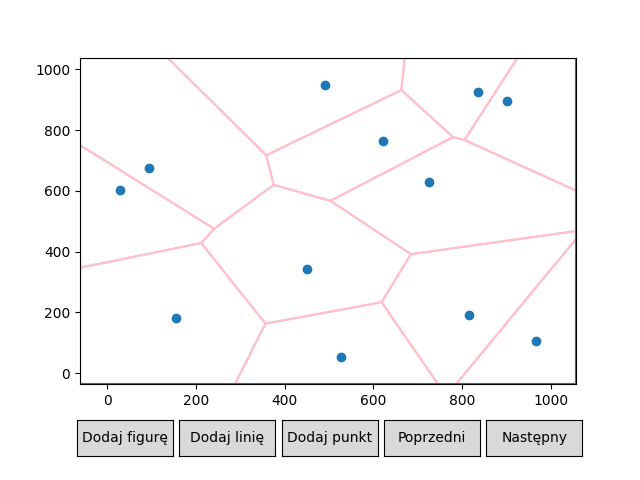

In [8]:
%matplotlib notebook

plot = Plot(scenes=visualization.getScenes())

plot.draw(False)

In [9]:
pprint(test)

{(30.0092332477514, 603.3284063768425),
 (94.18549534447429, 673.7832158740282),
 (155.29010908527553, 182.66033289479523),
 (449.65573260384315, 343.32975027275637),
 (492.2475499293315, 949.2209958812605),
 (527.4859034281553, 54.0878786808),
 (622.1297379828186, 764.979284704445),
 (725.6359156188247, 628.4822652932882),
 (815.1859768236852, 190.17089197254245),
 (835.135938968586, 925.15073618234),
 (902.2110841888684, 895.4543479941359),
 (965.7863751298918, 104.94826608082076)}
